<a href="https://colab.research.google.com/github/stchang-idm/nutrition_tb_workshop/blob/main/updated_sample_size_calculations_2024_02_24.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


# Sample Size Calculation for Multi-Arm Household-Level Trials

### Authors
- *Stewart Chang* (<stewart.chang@gatesfoundation.org>)
- *Arie Voorman* (<arend.voorman@gatesfoundation.org>)

## Introduction

This notebook demonstrates **sample size calculations** for **multi-arm** nutritional intervention trials with **household-level randomization** only.
Each trial design compares a **Control** arm (standard of care) vs. various **nutrient-based interventions**, without testing superiority between intervention arms.

Scenarios differ by:

1. **Number of Arms**: 3-arm, 4-arm, 5-arm, and 6-arm designs.
2. **Baseline Incidence Variation**: 1% to 5% in 1% increments (representing TB incidence in different global settings).
3. **Efficacy Variation**: 10% to 50% in 10% increments.
4. **Household ICC**: Set equal to the baseline incidence.
5. **Dropout Rate**: Assumed to be 10%, requiring sample size inflation.

### Trial Designs

| Design | Arms |
|--------|------|
| 3-arm | (a) Control vs. (b) Macronutrients + Micronutrients + High B vitamins vs. (c) Micronutrients + High B vitamins |
| 4-arm | (a) Control vs. (b) Macronutrients + Micronutrients + High B vitamins vs. (c) Micronutrients + High B vitamins vs. [(d) Micronutrients alone or (e) High B vitamins alone] |
| 4-arm | (a) Control vs. (b) Macronutrients + Micronutrients + High B vitamins vs. (e) High B vitamins alone vs. [(c) Micronutrients + High B vitamins or (d) Micronutrients alone] |
| 5-arm | (a) Control vs. (b) Macronutrients + Micronutrients + High B vitamins vs. (c) Micronutrients + High B vitamins vs. (d) Micronutrients alone vs. (e) High B vitamins alone |
| 6-arm | (a) Control vs. (b) Macronutrients + Micronutrients + High B vitamins vs. (c) Micronutrients + High B vitamins vs. (d) Micronutrients alone vs. (e) High B vitamins alone vs. (f) Macronutrients + Micronutrients |

### Key Assumptions

- **Significance Level** $(\alpha = 0.05)$
- **Power** $(1-\beta = 0.80)$
- **Baseline Incidence**: 1% to 5% in 1% increments.
- **Efficacy**: 10% to 50% in 10% increments.
- **Bonferroni correction for multiple comparisons**.
- **Dropout Rate**: 10% increase in total sample size.

---


## Import Libraries

In [89]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
import math
import seaborn as sns
from matplotlib.patches import Rectangle
import pandas as pd

%matplotlib inline

# Set global font sizes for better readability.
plt.rcParams.update({
    'font.size': 14,
    'axes.labelsize': 16,
    'xtick.labelsize': 14,
    'ytick.labelsize': 14,
    'axes.titlesize': 18,
    'legend.fontsize': 14
})

sns.set_style("whitegrid")


## Global Parameters

In [90]:
# Define parameters
alpha = 0.05
power = 0.80
Z_beta = stats.norm.ppf(power)

# Define baseline incidence and efficacy ranges
baseline_incidence_percent = np.arange(1, 6, 1)  # 1% to 5% in 1% increments
baseline_incidences = baseline_incidence_percent / 100.0

efficacies = np.arange(10, 60, 10) / 100.0  # 10% to 50% in 10% increments

# Household ICC set equal to baseline incidence
household_icc = baseline_incidences

# Dropout adjustment factor (10% increase)
dropout_adjustment = 1.1

# Household size (contacts only)
m_house = 4


## Sample Size Calculations: Household-Level

In [91]:
# Calculate the sample size needed according to key variables
def household_size_calc_multiarm(arms, p_control, eff, Z_alpha, Z_beta, DE, n_e=5):
    """
    Computes required sample size per arm for a given incidence, efficacy, and number of arms.

    Args:
        arms (int): Number of arms in the study (including control).
        p_control (float): Baseline incidence rate.
        eff (float): Efficacy rate.
        Z_alpha (float): Z-score for significance level.
        Z_beta (float): Z-score for power level.
        DE (float): Design effect.
        n_e (int, optional): Household size (default is 5).

    Returns:
        float: Total required sample size per arm adjusted for design effect.
    """
    p1 = p_control
    p2 = p_control * (1 - eff)
    delta = p1 - p2

    if abs(delta) < 1e-12:  # Prevent division by zero
        delta = 1e-12

    numerator = (Z_alpha + Z_beta) ** 2 * (p1 * (1 - p1) + p2 * (1 - p2))
    denominator = delta ** 2
    n_pg = numerator / denominator

    return n_pg * DE


# Function to generate sample size matrices for different arm designs
def generate_multiarm_sample_size_matrix(arms, baseline_incs, effic_arr, dropout_rate=1.1):
    """
    Generates a matrix of sample sizes for a given number of arms across different incidences and efficacies.

    Args:
        arms (int): Number of arms in the trial (including control).
        baseline_incs (array-like): Array of baseline incidence values.
        effic_arr (array-like): Array of efficacy values.
        dropout_rate (float, optional): Dropout adjustment factor. Defaults to 1.1.

    Returns:
        numpy.ndarray: Matrix containing the calculated total sample sizes for plotting.
    """

    scenario_matrix = np.zeros((len(effic_arr), len(baseline_incs)))

    for i, efficacy in enumerate(effic_arr):
        for j, p_control in enumerate(baseline_incs):
            alpha_adjusted = alpha / (arms - 1)  # Bonferroni correction for multiple comparisons
            Z_alpha = stats.norm.ppf(1 - alpha_adjusted / 2)

            r_house = household_icc[j] / (1 - household_icc[j])   # Assigning household ICC according to Chatfield 2020
            DE_house = 1 + (m_house - 1) * r_house

            n_pg = household_size_calc_multiarm(
                arms, p_control, efficacy,
                Z_alpha, Z_beta,
                DE_house,
                m_house
            )

            K_per_arm = math.ceil(n_pg / m_house)  # Number of households per arm
            tot_households = K_per_arm * arms  # Multiply by number of arms
            tot_contacts = tot_households * m_house  # Total household contacts

            # Adjust for dropout rate
            scenario_matrix[i, j] = math.ceil(tot_contacts * dropout_rate)

    return scenario_matrix


# Generate matrices for different arm trials (3, 4, 5, and 6 arms)
scenario_3arm = generate_multiarm_sample_size_matrix(3, baseline_incidences, efficacies)
scenario_4arm = generate_multiarm_sample_size_matrix(4, baseline_incidences, efficacies)
scenario_5arm = generate_multiarm_sample_size_matrix(5, baseline_incidences, efficacies)
scenario_6arm = generate_multiarm_sample_size_matrix(6, baseline_incidences, efficacies)

# Return the generated matrices for inspection
scenario_3arm, scenario_4arm, scenario_5arm, scenario_6arm


(array([[608177., 310214., 210884., 161238., 131446.],
        [144105.,  73538.,  50015.,  38254.,  31205.],
        [ 60509.,  30889.,  21015.,  16091.,  13121.],
        [ 32050.,  16369.,  11141.,   8528.,   6957.],
        [ 19233.,   9821.,   6693.,   5122.,   4185.]]),
 array([[893165., 455559., 309708., 236791., 193037.],
        [211641., 107994.,  73445.,  56180.,  45831.],
        [ 88863.,  45373.,  30871.,  23620.,  19272.],
        [ 47063.,  24042.,  16369.,  12532.,  10226.],
        [ 28249.,  14433.,   9821.,   7516.,   6143.]]),
 array([[1189166.,  606540.,  412347.,  315260.,  257005.],
        [ 281776.,  143792.,   97791.,   74800.,   61007.],
        [ 118317.,   60413.,   41096.,   31461.,   25675.],
        [  62657.,   32011.,   21780.,   16676.,   13619.],
        [  37598.,   19206.,   13091.,   10010.,    8185.]]),
 array([[1494557.,  762301.,  518233.,  396212.,  323004.],
        [ 354130.,  180709.,  122919.,   94011.,   76692.],
        [ 148712.,   759

## Plot Sample Size Results

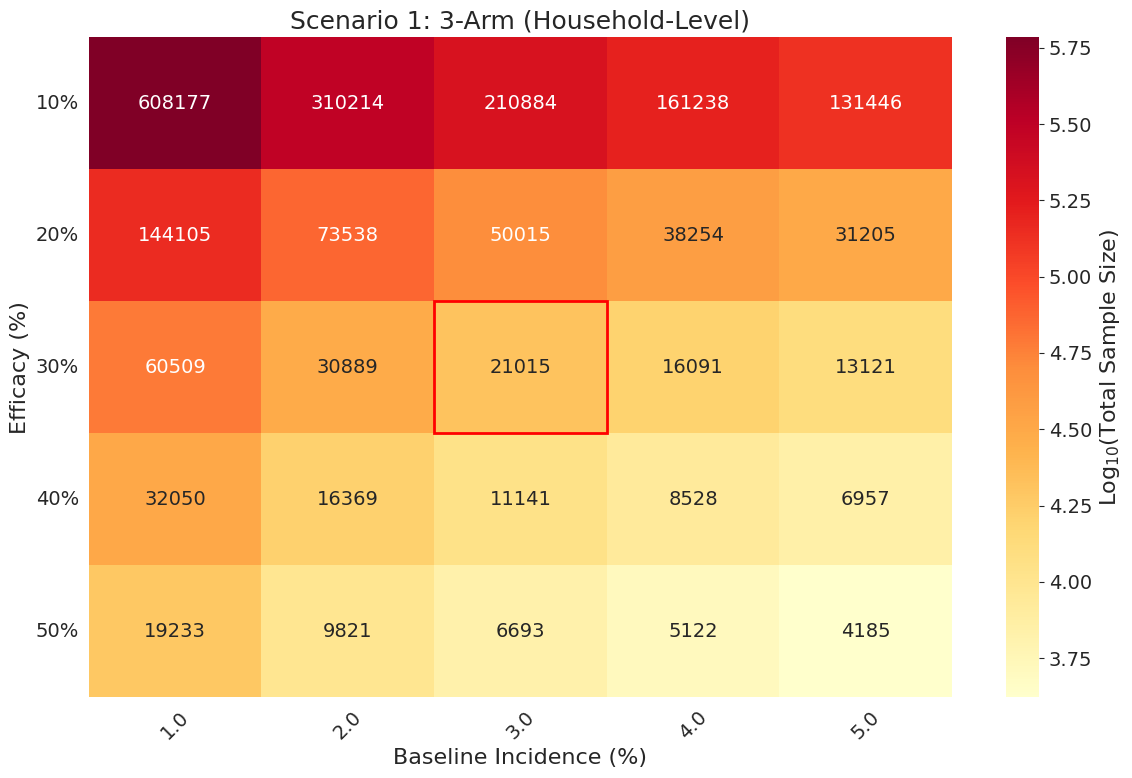

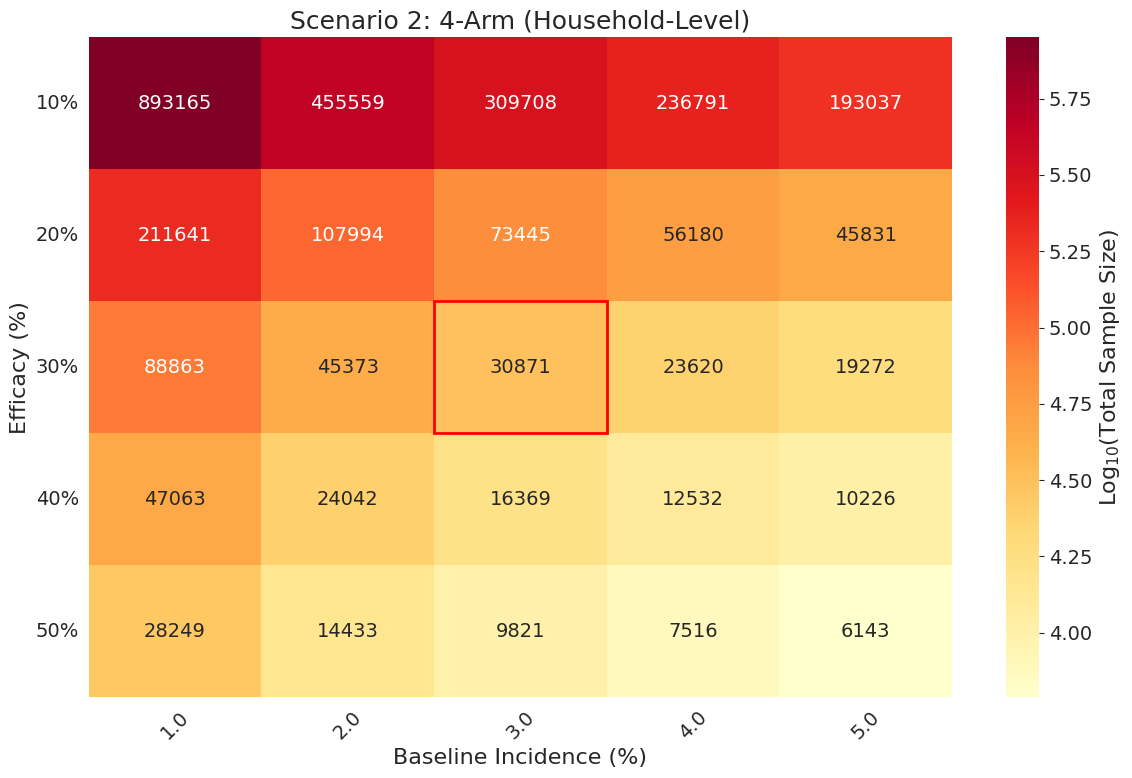

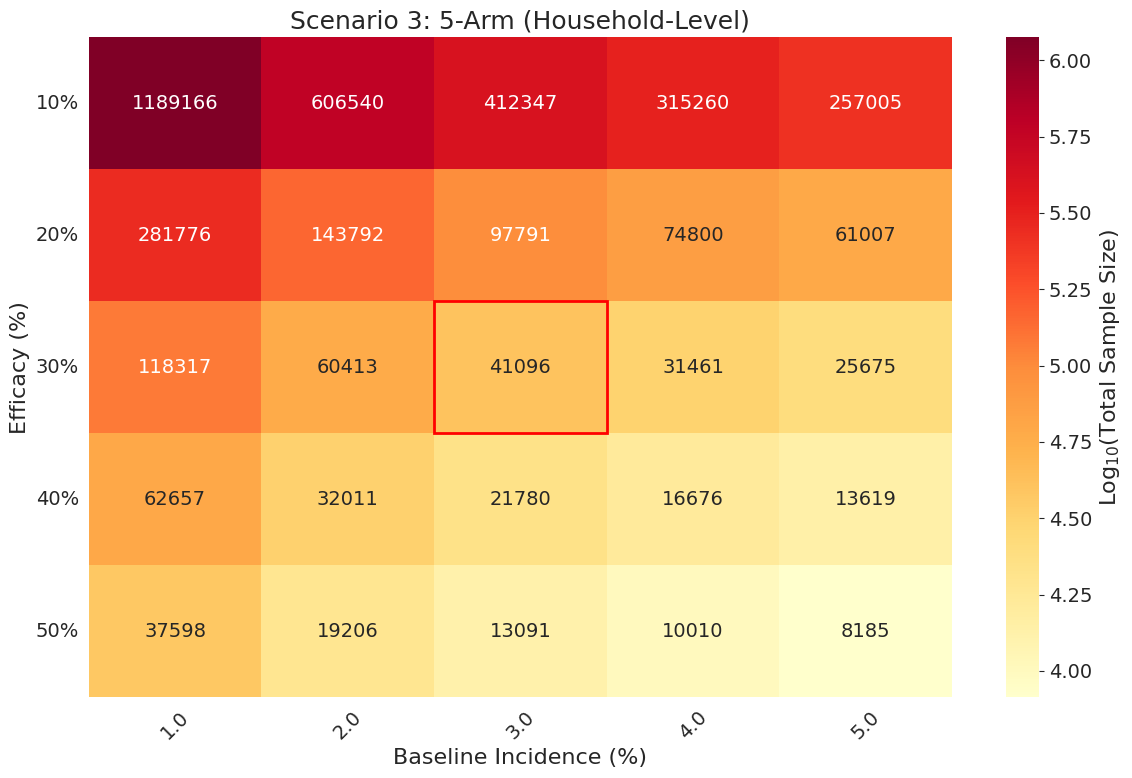

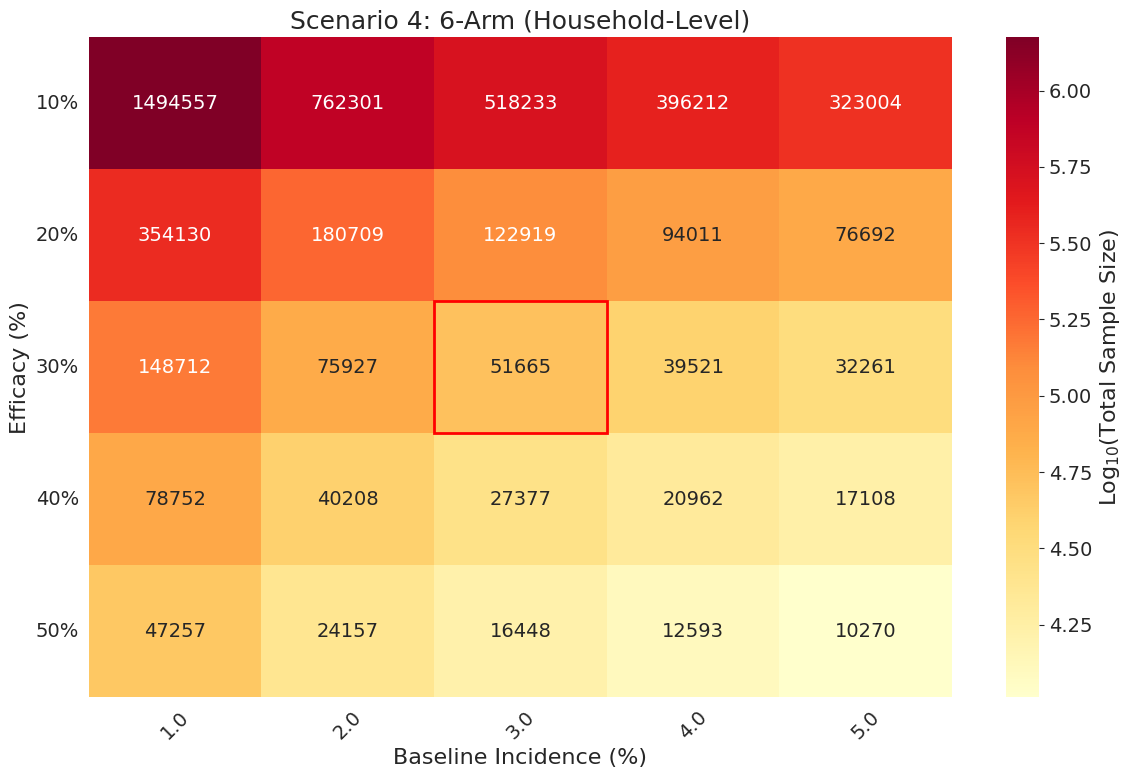

In [92]:
# Plot the sample sizes needed as a 2D heatmap
def plot_sample_size_heatmap(sample_size_matrix, baseline_incs, effic_arr, scenario_name, cmap="YlOrRd"):
    """
    Generates a heatmap to visualize sample size calculations for multi-arm household-level trials.

    Args:
        sample_size_matrix (numpy.ndarray): Matrix of calculated total sample sizes.
        baseline_incs (array-like): Array of baseline incidence values.
        effic_arr (array-like): Array of efficacy values.
        scenario_name (str): Title for the heatmap.
        cmap (str, optional): Colormap for the heatmap. Defaults to "YlOrRd".

    Returns:
        None
    """

    # Log transform for better visualization
    log_sample_size_matrix = np.log10(sample_size_matrix)

    # Create the heatmap
    fig, ax = plt.subplots(figsize=(12, 8))
    sns.heatmap(
        log_sample_size_matrix,
        annot=sample_size_matrix.astype(int),  # Annotate with actual sample size
        fmt="",
        annot_kws={"size": 14},
        cmap=cmap,
        xticklabels=[f"{b:.1f}" for b in baseline_incidence_percent],
        yticklabels=[f"{int(e * 100)}%" for e in effic_arr],
        cbar_kws={"label": "Log$_{10}$(Total Sample Size)"},
        ax=ax
    )

    ax.set_title(scenario_name, fontsize=18)
    ax.set_xlabel("Baseline Incidence (%)", fontsize=16)
    ax.set_ylabel("Efficacy (%)", fontsize=16)
    plt.xticks(rotation=45)
    plt.yticks(rotation=0)
    ax.tick_params(labelsize=14)

    # Highlight baseline incidence = 3% and efficacy = 30% with a red box (if present in the array)
    baseline_index = np.where(baseline_incs == 0.03)[0]
    efficacy_index = np.where(effic_arr == 0.30)[0]
    if len(baseline_index) > 0 and len(efficacy_index) > 0:
        rect = Rectangle((baseline_index[0], efficacy_index[0]), 1, 1, fill=False, edgecolor='red', linewidth=2)
        ax.add_patch(rect)

    plt.tight_layout()
    plt.show()

plot_sample_size_heatmap(scenario_3arm, baseline_incidences, efficacies, "Scenario 1: 3-Arm (Household-Level)")
plot_sample_size_heatmap(scenario_4arm, baseline_incidences, efficacies, "Scenario 2: 4-Arm (Household-Level)")
plot_sample_size_heatmap(scenario_5arm, baseline_incidences, efficacies, "Scenario 3: 5-Arm (Household-Level)")
plot_sample_size_heatmap(scenario_6arm, baseline_incidences, efficacies, "Scenario 4: 6-Arm (Household-Level)")

In [99]:
!pip install ace_tools

In [106]:
import pandas as pd

# Define the number of household contacts per household
m_house = 4

# Define the relevant incidence scenarios (3% for Indonesia, 4% for Africa)
incidence_scenarios = [0.03, 0.04]

# Define arm scenarios
arm_scenarios = [3, 4, 5, 6]

# Create an empty list to store table data
table_data = []

# Loop through arm and incidence scenarios to populate the table
for arms in arm_scenarios:
    scenario_matrix = generate_multiarm_sample_size_matrix(arms, baseline_incidences, efficacies)

    for incidence in incidence_scenarios:
        # Find the corresponding index in baseline_incidences
        j = np.where(baseline_incidences == incidence)[0][0]

        # Select the scenario_matrix row that corresponds to 30% efficacy
        i = np.where(efficacies == 0.30)[0][0]

        # Retrieve the total number of household contacts (HHCs) overall
        num_hhcs_overall = scenario_matrix[i, j]

        # Calculate number of households overall
        num_hh_overall = num_hhcs_overall / m_house

        # Calculate number of HHCs per arm
        num_hhcs_per_arm = num_hhcs_overall / arms

        # Convert incidence to country-based notation
        incidence_label = "3% for Indonesia" if incidence == 0.03 else "4% for Africa"

        # Append the row data
        table_data.append([arms, incidence_label, int(num_hh_overall), int(num_hhcs_overall), int(num_hhcs_per_arm)])

# Convert list to DataFrame
df_results = pd.DataFrame(table_data, columns=[
    "Number of Arms", "2-Year TB Incidence Control", "Number of HH Overall",
    "Number of HHCs Overall", "Number of HHCs per Arm"
])

# Save the DataFrame to a CSV file
csv_output_path = "sample_size_results.csv"
df_results.to_csv(csv_output_path, index=False)

# Display the DataFrame using Pandas
from IPython.display import display

# Show the formatted table in the notebook
display(df_results)

,Number of Arms,2-Year TB Incidence Control,Number of HH Overall,Number of HHCs Overall,Number of HHCs per Arm
0,3,3% for Indonesia,5253,21015,7005
1,3,4% for Africa,4022,16091,5363
2,4,3% for Indonesia,7717,30871,7717
3,4,4% for Africa,5905,23620,5905
4,5,3% for Indonesia,10274,41096,8219
5,5,4% for Africa,7865,31461,6292
6,6,3% for Indonesia,12916,51665,8610
7,6,4% for Africa,9880,39521,6586


# Conclusion

This notebook presents **sample size calculations** for **multi-arm household-level trials**, ranging from **3-arm** to **6-arm** designs, each tested against a **Control** arm. Our analysis quantifies the effect of **baseline incidence**, **efficacy**, and **number of trial arms** on total sample sizes.

## Key Findings:

### Impact of TB Incidence (3% vs. 4%)
- Higher baseline incidence (**4% for Africa**) consistently requires **fewer participants** than lower incidence (**3% for Indonesia**), as expected from power calculations.
- A **1 percentage point increase** in incidence reduces the required sample size **by approximately 20-30%**, depending on the number of arms.

### Effect of Efficacy (10% to 50%)
- Higher assumed intervention efficacy leads to **smaller required sample sizes** across all study designs.
- Trials assuming **30% efficacy** were used as the reference scenario.

### Scaling to Multi-Arm Designs (3-6 Arms)
- Adding **more intervention arms** increases the **total sample size** but reduces the **per-arm sample size**.
- A **6-arm** trial requires **nearly 2.5× the total sample size** of a **3-arm** trial.
- However, per-arm comparisons remain **statistically efficient**, benefiting from Bonferroni adjustments.

### Household-Level Randomization Benefits
- ICC adjustments using **Chatfield (2020) scaling** show that **household-level randomization leads to lower design effects**, reducing required sample sizes.
- The impact of ICC is **greater for lower-incidence settings (Indonesia, 3%)**.

This work informs trial design trade-offs, demonstrating that **higher efficacy assumptions and increased incidence rates significantly reduce required sample sizes**, while multi-arm trials maintain efficiency despite requiring larger overall sample sizes.


---

# References

- **Chatfield, M. D., & Farewell, D. M. (2020).** Understanding between-cluster variation in prevalence, and limits for how much variation is plausible. *Statistical Methods in Medical Research, 30*(1), 3–18. [https://doi.org/10.1177/0962280220951831](https://doi.org/10.1177/0962280220951831)

